In [1]:
# Load packages.
import pandas as pd
import numpy as np
import matplotlib



import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns


from datetime import datetime as dt
from datetime import timedelta


import yfinance as yf


import statsmodels.formula.api as sm
from statsmodels.iolib.summary2 import summary_col

# SAMPLE CODE

In [88]:
# Fama-French 3 Factor data and convert to daily returns.
url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_daily_CSV.zip"

# Define headers.
headers = ["date","Mkt-RF","SMB","HML","RF"]

# Load the FF3 and RF data.
ff = pd.read_csv(url, skiprows=5, names=headers)
ff = ff.iloc[:25607]
ff["date"] = pd.to_datetime(ff["date"],format="%Y%m%d") # Convert date into a datetime object.
ff.rename(columns={"Mkt-RF":"Mkt_RF"}, inplace=True)    # Rename column.

# Convert column values to decimals from percentages.
ff[ff.columns[1:]] = ff[ff.columns[1:]] / 100

# Download daily security data and convert to daily returns.
start = dt(2023, 1, 1)
end = dt(2023, 6, 1)
tickers = ["SPY","MSFT","BAC","JNJ","XOM"]
df = yf.download(" ".join(tickers),start,end)["Adj Close"]
df = df.pct_change()[1:] # turn the price dataframe into returns
df = df.reset_index().rename(columns={"Date":"date"})

# Merge FF3 and RF data to the security data.
df = pd.merge(df, ff, how="left", left_on=["date"], right_on=["date"])

[*********************100%%**********************]  5 of 5 completed


In [89]:
# Portfolio from January 1, 2023 to March 1, 2023.
p11 = df[df.date.between(dt(2023,1,1),dt(2023,3,1))]["MSFT"]
p31 = df[df.date.between(dt(2023,1,1),dt(2023,4,1))]["MSFT"]

# Portfolio from March 1, 2023 onwards.
p12 = 1/3*df[df.date > dt(2023,3,1)]["BAC"] + 1/3*df[df.date > dt(2023,3,1)]["XOM"] + 1/3*df[df.date > dt(2023,3,1)]["JNJ"]
p22 = 0.4*df[df.date > dt(2023,3,1)]["MSFT"] + 0.2*df[df.date > dt(2023,3,1)]["BAC"] + 0.2*df[df.date > dt(2023,3,1)]["XOM"] + 0.2*df[df.date > dt(2023,3,1)]["JNJ"]
p32 = 0.4*df[df.date > dt(2023,4,1)]["MSFT"] + 0.2*df[df.date > dt(2023,4,1)]["BAC"] + 0.2*df[df.date > dt(2023,4,1)]["XOM"] + 0.2*df[df.date > dt(2023,4,1)]["JNJ"]

df["Portfolio1"] = pd.concat([p11,p12])
df["Portfolio2"] = pd.concat([p11,p22])
df["Portfolio3"] = pd.concat([p31,p32])

# Compute *excess* returns for the securities.
for col in ["SPY","MSFT","BAC","XOM","JNJ","Portfolio1","Portfolio2","Portfolio3"]:
  df[col+"e"] = df[col] - df["RF"]

df.head()

,date,BAC,JNJ,MSFT,SPY,XOM,Mkt_RF,SMB,HML,RF,...,Portfolio2,Portfolio3,SPYe,MSFTe,BACe,XOMe,JNJe,Portfolio1e,Portfolio2e,Portfolio3e
0,2023-01-04,0.018800,0.010887,-0.043743,0.007720,0.002910,0.0081,0.0054,0.0004,0.00017,...,-0.043743,-0.043743,0.007550,-0.043913,0.018630,0.002740,0.010717,-0.043913,-0.043913,-0.043913
1,2023-01-05,-0.002050,-0.007384,-0.029638,-0.011414,0.022374,-0.0114,-0.0018,0.0121,0.00017,...,-0.029638,-0.029638,-0.011584,-0.029808,-0.002220,0.022204,-0.007554,-0.029808,-0.029808,-0.029808
2,2023-01-06,0.009979,0.008110,0.011785,0.022932,0.012087,0.0221,-0.0006,0.0004,0.00017,...,0.011785,0.011785,0.022762,0.011615,0.009809,0.011917,0.007940,0.011615,0.011615,0.011615
3,2023-01-09,-0.015112,-0.025908,0.009736,-0.000567,-0.018637,0.0004,0.0055,-0.0124,0.00017,...,0.009736,0.009736,-0.000737,0.009566,-0.015282,-0.018807,-0.026078,0.009566,0.009566,0.009566
4,2023-01-10,0.006786,-0.002392,0.007617,0.007013,0.014935,0.0080,0.0091,-0.0057,0.00017,...,0.007617,0.007617,0.006843,0.007447,0.006616,0.014765,-0.002562,0.007447,0.007447,0.007447


In [90]:
# CAPM Regression: alpha and beta.
# CAPM Regressions
reg1 = sm.ols("Portfolio1e ~ Mkt_RF", data=df).fit()
reg2 = sm.ols("Portfolio2e ~ Mkt_RF", data=df).fit()
reg3 = sm.ols("Portfolio3e ~ Mkt_RF", data=df).fit()

# FF3 Regressions
ff1 = sm.ols("Portfolio1e ~ Mkt_RF + SMB + HML", data=df).fit()
ff2 = sm.ols("Portfolio2e ~ Mkt_RF + SMB + HML", data=df).fit()
ff3 = sm.ols("Portfolio3e ~ Mkt_RF + SMB + HML", data=df).fit()

### Summarize the models.
#print(reg1.summary())
#print(summary_col([reg1,reg2,reg3], float_format="%0.4f", stars=True))
print(summary_col([ff1,ff2,ff3], float_format="%0.2f", stars=True))


               Portfolio1e Portfolio2e Portfolio3e
--------------------------------------------------
Intercept      -0.00       -0.00       -0.00      
               (0.00)      (0.00)      (0.00)     
Mkt_RF         1.22***     1.19***     1.12***    
               (0.12)      (0.11)      (0.12)     
SMB            -0.14       -0.30*      -0.48**    
               (0.20)      (0.17)      (0.19)     
HML            0.26*       -0.24**     -0.65***   
               (0.14)      (0.12)      (0.13)     
R-squared      0.53        0.60        0.58       
R-squared Adj. 0.51        0.59        0.56       
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


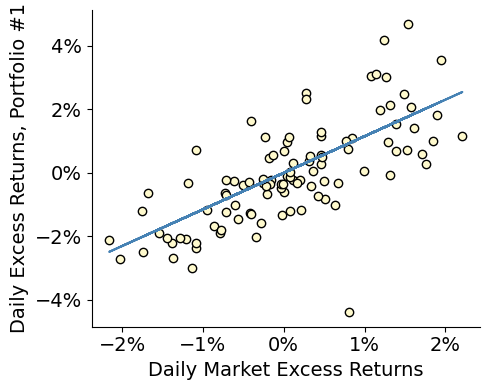

In [91]:
# Daily returns
fig, ax=plt.subplots(figsize=(5,4))
ax.scatter(df.Mkt_RF * 100, df.Portfolio1e * 100, c="lemonchiffon", ec="black", zorder=1)

# regression line
ax.plot(df.Mkt_RF*100, reg1.params.Intercept + reg1.params.Mkt_RF * df.Mkt_RF*100, c="steelblue", zorder=2)

ax.tick_params(axis = "both", labelsize = 14)
ax.set_xlabel("Daily Market Excess Returns",fontsize=14)
ax.set_ylabel("Daily Excess Returns, Portfolio #1",fontsize=14)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

sns.despine()
plt.tight_layout()

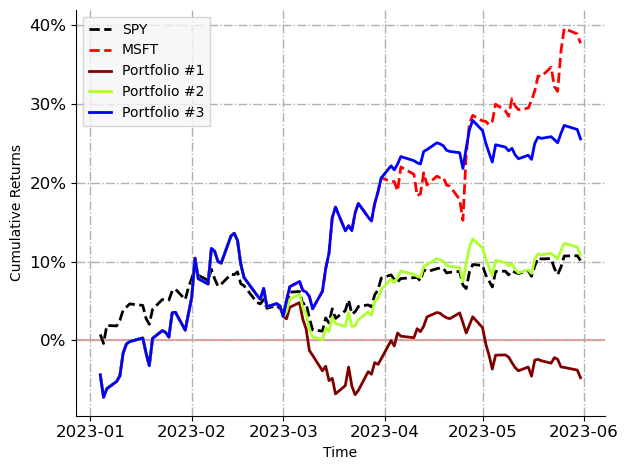

In [92]:
# Cumulative returns.
for col in ["SPY","MSFT","BAC","XOM","JNJ","Portfolio1","Portfolio2","Portfolio3"]:
  df[col+"_cum"] = (1 + df[col]).cumprod() - 1

fig, ax=plt.subplots()
ax.plot(df.date, df.SPY_cum*100, color="black",ls="--", zorder=3,lw=2,label="SPY")
ax.plot(df.date, df.MSFT_cum*100, color="red",ls="--", zorder=3,lw=2,label="MSFT")
#ax.plot(df.date, df.BAC_cum*100, color="orange",ls="-", zorder=3,lw=2,label="BAC")
#ax.plot(df.date, df.XOM_cum*100, color="green",ls="-", zorder=3,lw=2,label="XOM")
#ax.plot(df.date, df.JNJ_cum*100, color="purple",ls="-", zorder=3,lw=2,label="JNJ")
ax.plot(df.date, df.Portfolio1_cum*100, color="maroon",ls="-", zorder=3,lw=2,label="Portfolio #1")
ax.plot(df.date, df.Portfolio2_cum*100, color="greenyellow",ls="-", zorder=3,lw=2,label="Portfolio #2")
ax.plot(df.date, df.Portfolio3_cum*100, color="blue",ls="-", zorder=3,lw=2,label="Portfolio #3")
ax.axhline(0, color="red",zorder=1,alpha=0.4)
ax.grid(lw=1, ls="-.")

# Legend
legend = ax.legend(frameon=True,fancybox=False,loc="upper left",handlelength=1.6,facecolor="whitesmoke")

# Set size of xticks and yticks to 12
ax.tick_params(axis = "both", labelsize = 12)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
# Label x and y axes
ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Returns")
sns.despine()
plt.tight_layout()

In [93]:
df.Portfolio1_cum.iloc[-1]*100 / len(df) * 252

-11.666185844743477

In [94]:
df

,date,BAC,JNJ,MSFT,SPY,XOM,Mkt_RF,SMB,HML,RF,...,Portfolio2e,Portfolio3e,SPY_cum,MSFT_cum,BAC_cum,XOM_cum,JNJ_cum,Portfolio1_cum,Portfolio2_cum,Portfolio3_cum
0,2023-01-04,0.018800,0.010887,-0.043743,0.007720,0.002910,0.0081,0.0054,0.0004,0.00017,...,-0.043913,-0.043913,0.007720,-0.043743,0.018800,0.002910,0.010887,-0.043743,-0.043743,-0.043743
1,2023-01-05,-0.002050,-0.007384,-0.029638,-0.011414,0.022374,-0.0114,-0.0018,0.0121,0.00017,...,-0.029808,-0.029808,-0.003781,-0.072084,0.016712,0.025350,0.003423,-0.072084,-0.072084,-0.072084
2,2023-01-06,0.009979,0.008110,0.011785,0.022932,0.012087,0.0221,-0.0006,0.0004,0.00017,...,0.011615,0.011615,0.019064,-0.061149,0.026858,0.037743,0.011561,-0.061149,-0.061149,-0.061149
3,2023-01-09,-0.015112,-0.025908,0.009736,-0.000567,-0.018637,0.0004,0.0055,-0.0124,0.00017,...,0.009566,0.009566,0.018486,-0.052008,0.011340,0.018402,-0.014647,-0.052008,-0.052008,-0.052008
4,2023-01-10,0.006786,-0.002392,0.007617,0.007013,0.014935,0.0080,0.0091,-0.0057,0.00017,...,0.007447,0.007447,0.025629,-0.044787,0.018203,0.033612,-0.017004,-0.044787,-0.044787,-0.044787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,2023-05-24,-0.016795,-0.000956,-0.004473,-0.007245,0.011184,-0.0072,-0.0032,-0.0019,0.00016,...,-0.003263,-0.003263,0.083606,0.316153,-0.156006,0.026745,-0.107822,-0.023877,0.103759,0.250910
98,2023-05-25,0.002491,-0.014362,0.038458,0.008660,-0.017938,0.0064,-0.0071,-0.0108,0.00016,...,0.009261,0.009261,0.092990,0.366769,-0.153903,0.008327,-0.120635,-0.033576,0.114158,0.262695
99,2023-05-26,0.004970,-0.000389,0.021386,0.012951,-0.006530,0.0132,0.0004,-0.0087,0.00016,...,0.008004,0.008004,0.107145,0.395999,-0.149698,0.001743,-0.120977,-0.034204,0.123255,0.273005
100,2023-05-30,-0.001766,0.000130,-0.005047,0.000381,-0.008860,-0.0001,-0.0015,-0.0041,0.00016,...,-0.004278,-0.004278,0.107567,0.388953,-0.151200,-0.007133,-0.120863,-0.037584,0.118629,0.267762


In [85]:

p1   = [df.Portfolio1_cum.iloc[-1]*100, reg1.params[0]*100*252, ff1.params[0]*100*252, reg1.params[1], np.std(df.Portfolio1e)*np.sqrt(252)*100, np.std(reg1.resid)*np.sqrt(252)*100, np.mean(df.Portfolio1e)/np.std(df.Portfolio1e)*np.sqrt(252), np.mean(df.Portfolio1e)/reg1.params[1]*np.sqrt(252)*100]
p2   = [df.Portfolio2_cum.iloc[-1]*100, reg2.params[0]*100*252, ff2.params[0]*100*252, reg2.params[1], np.std(df.Portfolio2e)*np.sqrt(252)*100, np.std(reg2.resid)*np.sqrt(252)*100, np.mean(df.Portfolio2e)/np.std(df.Portfolio2e)*np.sqrt(252), np.mean(df.Portfolio2e)/reg2.params[1]*np.sqrt(252)*100]
p3   = [df.Portfolio3_cum.iloc[-1]*100, reg3.params[0]*100*252, ff3.params[0]*100*252, reg3.params[1], np.std(df.Portfolio3e)*np.sqrt(252)*100, np.std(reg3.resid)*np.sqrt(252)*100, np.mean(df.Portfolio3e)/np.std(df.Portfolio3e)*np.sqrt(252), np.mean(df.Portfolio3e)/reg3.params[1]*np.sqrt(252)*100]
spy  = [df.SPY_cum.iloc[-1]*100, 0, 0, 1, np.std(df.SPYe)*np.sqrt(252)*100, 0, np.mean(df.SPYe)/np.std(df.SPYe)*np.sqrt(252), np.mean(df.SPYe)/1*np.sqrt(252)*100]
msft = [df.MSFT_cum.iloc[-1]*100, 0, 0, 1, np.std(df.MSFTe)*np.sqrt(252)*100, 0, np.mean(df.MSFTe)/np.std(df.MSFTe)*np.sqrt(252), np.mean(df.MSFTe)/1*np.sqrt(252)*100]
bac = [df.BAC_cum.iloc[-1]*100, 0, 0, 1, np.std(df.BACe)*np.sqrt(252)*100, 0, np.mean(df.BACe)/np.std(df.BACe)*np.sqrt(252), np.mean(df.BACe)/1*np.sqrt(252)*100]
jnj = [df.JNJ_cum.iloc[-1]*100, 0, 0, 1, np.std(df.JNJe)*np.sqrt(252)*100, 0, np.mean(df.JNJe)/np.std(df.JNJe)*np.sqrt(252), np.mean(df.JNJe)/1*np.sqrt(252)*100]
xom = [df.XOM_cum.iloc[-1]*100, 0, 0, 1, np.std(df.XOMe)*np.sqrt(252)*100, 0, np.mean(df.XOMe)/np.std(df.XOMe)*np.sqrt(252), np.mean(df.XOMe)/1*np.sqrt(252)*100]

tt = pd.DataFrame()
tt["Portfolio #1"] = p1
tt["Portfolio #2"] = p2
tt["Portfolio #3"] = p3
tt["SPY"] = spy

tt = tt.T.rename(columns={0:"Total Return (%)", 1:"CAPM Alpha (%)", 2:"FF3 Alpha (%)", 3:"CAPM Beta", 4:"Total Risk (%)", 5:"Idiosyncratic Risk (%)", 6:"Sharpe Ratio", 7:"Treynor Ratio"#, 8:"M2", 9:"T2"
                          })

tt.round(2)

,Total Return (%),CAPM Alpha (%),FF3 Alpha (%),CAPM Beta,Total Risk (%),Idiosyncratic Risk (%),Sharpe Ratio,Treynor Ratio
Portfolio #1,-4.72,-36.24,-24.55,1.15,25.37,17.88,-0.51,-0.71
Portfolio #2,10.81,0.76,-13.53,1.14,23.52,15.26,1.01,1.31
Portfolio #3,25.58,33.26,-2.76,1.09,25.18,18.56,2.19,3.20
SPY,10.14,0.00,0.00,1.00,15.13,0.00,1.37,1.31


In [86]:
w = (np.std(df.Mkt_RF) / np.std(df.Portfolio3e))
M2 = w * np.mean(df.Portfolio3e) + (1-w) * (np.mean(df.Mkt_RF))

print("M^2 of portfolio #3 is %0.2f%%." %(M2*np.sqrt(252)*100))

w = (1 / reg3.params[1])
M2 = w * np.mean(df.Portfolio3e) + (1-w) * (np.mean(df.Mkt_RF))

print("T^2 of portfolio #3 is %0.2f%%." %(M2*np.sqrt(252)*100))

M^2 of portfolio #3 is 2.64%.
T^2 of portfolio #3 is 3.30%.


# CHOOSING STOCKS 

In [4]:
def get_info_yfinance(tickers):
    try:
        detail = yf.Ticker(tickers)
        bookvalue_per_share = detail.info.get('bookValue')
    except:
        bookvalue_per_share = np.nan
    return bookvalue_per_share

In [5]:
xsvm_df = pd.read_csv("XSVM holdings.csv")
xsvm_df = xsvm_df[0:119]
xsvm_df = xsvm_df['Holding Ticker']
xsvm_df = pd.DataFrame(xsvm_df)
xsvm_df

,Holding Ticker
0,KELYA
1,VTLE
2,JXN
3,FDP
4,XRX
...,...
114,SMP
115,SVC
116,HCC
117,CEIX


In [95]:
temp_lst = []
for i in xsvm_df['Holding Ticker'].tolist():
    temp_lst.append(get_info_yfinance(str(i).strip()))

xsvm_out = xsvm_df.copy() 
xsvm_out['BVPS'] = temp_lst
xsvm_out = xsvm_out.dropna()
xsvm_out

,Holding Ticker,BVPS
0,KELYA,35.538
1,VTLE,82.378
2,JXN,122.514
3,FDP,39.814
4,XRX,20.610
...,...,...
113,OSUR,5.857
114,SMP,28.976
115,SVC,7.397
116,HCC,36.034


In [96]:
#picking the highest 10 book value stocks
top10 = xsvm_out.sort_values(by=['BVPS'], ascending=False).head(10)
top10

,Holding Ticker,BVPS
20,GPI,200.104
24,ABG,159.545
60,MTH,126.613
2,JXN,122.514
105,AMR,121.645
87,WIRE,111.914
33,AGO,101.693
38,MHO,90.664
1,VTLE,82.378
42,ALGT,75.223


In [117]:
port_tickers = top10['Holding Ticker'].values
port_tickers = [i.strip() for i in my_tickers]
port_tickers

['GPI', 'ABG', 'MTH', 'JXN', 'AMR', 'WIRE', 'AGO', 'MHO', 'VTLE', 'ALGT']

# Writing Functions

In [131]:
def returns_df (date_time_start, date_time_end, tickers):
    # Fama-French 3 Factor data and convert to daily returns.
    url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_daily_CSV.zip"
    # Define headers.
    headers = ["date","Mkt-RF","SMB","HML","RF"]
    # Load the FF3 and RF data.
    ff = pd.read_csv(url, skiprows=5, names=headers)
    ff = ff.iloc[:25607]
    ff["date"] = pd.to_datetime(ff["date"],format="%Y%m%d") # Convert date into a datetime object.
    ff.rename(columns={"Mkt-RF":"Mkt_RF"}, inplace=True)    # Rename column.
    # Convert column values to decimals from percentages.
    ff[ff.columns[1:]] = ff[ff.columns[1:]] / 100    
    # Download daily security data and convert to daily returns.
    start = date_time_start
    end = date_time_end

    df = yf.download(" ".join(tickers),start,end)["Adj Close"]
    df = df.pct_change()[1:] # turn the price dataframe into returns
    df = df.reset_index().rename(columns={"Date":"date"})
    # Merge FF3 and RF data to the security data.
    df = pd.merge(df, ff, how="left", left_on=["date"], right_on=["date"])
    
    return df

#---------------------------------------------------------------------------------------------------
def excess_returns (data, ticker_lst):
    for j in ticker_lst:
        data[j+"e"] = data[j] - data["RF"]
    return data

#---------------------------------------------------------------------------------------------------
def create_portfolio (data, ticker_lst, weights_lst, ):
    out = 0
    j = 0
    for i in range(len(ticker_lst)):
        out += weights_lst[j]*data[ticker_lst[i]]
    return out

#---------------------------------------------------------------------------------------------------
def cumulative_returns (data, tickers_and_portfolios, ):
    for col in tickers_and_portfolios:
        data[col+"_cum"] = (1 + data[col]).cumprod() - 1
    return data

#---------------------------------------------------------------------------------------------------


# Testing on my portfolio of 10

In [132]:
final_tickers = port_tickers.copy()
final_tickers.append('SPY')


tmp = returns_df(dt(2023,6,1), dt(2023,10,30), final_tickers)
tmp['port_1'] = create_portfolio(tmp, port_tickers, [.1 for i in range(10)])
final_tickers.append('port_1')
tmp = excess_returns(tmp, final_tickers)
tmp

[*********************100%%**********************]  11 of 11 completed


,date,ABG,AGO,ALGT,AMR,GPI,JXN,MHO,MTH,SPY,...,MTHe,JXNe,AMRe,WIREe,AGOe,MHOe,VTLEe,ALGTe,SPYe,port_1e
0,2023-06-02,0.066377,0.032895,0.076504,0.029679,0.052200,0.049256,0.030337,0.042496,0.014461,...,0.042306,0.049066,0.029489,0.057794,0.032705,0.030147,0.027483,0.076314,0.014271,0.046350
1,2023-06-05,-0.034464,-0.019483,-0.016525,-0.014619,-0.026838,-0.022290,-0.005615,-0.010719,-0.001916,...,-0.010909,-0.022480,-0.014809,-0.004532,-0.019673,-0.005805,-0.024816,-0.016715,-0.002106,-0.018142
2,2023-06-06,0.043610,0.027512,0.051185,0.037369,0.048120,0.028325,0.036772,0.056390,0.002177,...,0.056200,0.028135,0.037179,0.026979,0.027322,0.036582,0.025058,0.050995,0.001987,0.037980
3,2023-06-07,0.045149,0.006880,0.001386,0.038451,0.032398,0.033927,0.006908,0.012821,-0.003458,...,0.012631,0.033737,0.038261,0.055522,0.006690,0.006718,0.048141,0.001196,-0.003648,0.028006
4,2023-06-08,0.003477,-0.005725,0.006920,-0.035663,0.001057,-0.025016,-0.006201,-0.014730,0.006049,...,-0.014920,-0.025206,-0.035853,-0.016929,-0.005915,-0.006391,0.012982,0.006730,0.005859,-0.008135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,2023-10-23,-0.027112,-0.012506,-0.018961,-0.006742,-0.020242,0.002281,0.024927,0.010734,-0.001733,...,0.010524,0.002071,-0.006952,0.003268,-0.012716,0.024717,-0.039911,-0.019171,-0.001943,-0.008594
99,2023-10-24,-0.063467,0.007599,-0.008482,0.001101,-0.024013,0.000506,0.011185,-0.005533,0.007539,...,-0.005743,0.000296,0.000891,-0.011373,0.007389,0.010975,-0.006279,-0.008692,0.007329,-0.010044
100,2023-10-25,-0.008578,0.010726,-0.035900,0.008247,0.029842,-0.022997,0.029325,-0.014179,-0.014352,...,-0.014389,-0.023207,0.008037,0.039776,0.010516,0.029115,-0.001164,-0.036110,-0.014562,0.003342
101,2023-10-26,0.022280,0.009949,0.007127,0.001454,0.040319,-0.009571,0.020742,0.014747,-0.011975,...,0.014537,-0.009781,0.001244,0.012244,0.009739,0.020532,-0.010523,0.006917,-0.012185,0.010709


# Stats

In [ ]:
# CAPM Regressions
reg1 = sm.ols("port_1e ~ Mkt_RF", data=data).fit()
reg2 = sm.ols("port_2e ~ Mkt_RF", data=data).fit()
reg3 = sm.ols("port_3e ~ Mkt_RF", data=data).fit()

# FF3 Regressions
ff1 = sm.ols("port_1e ~ Mkt_RF + SMB + HML", data=data).fit()
ff2 = sm.ols("port_2e ~ Mkt_RF + SMB + HML", data=data).fit()
ff3 = sm.ols("port_3e ~ Mkt_RF + SMB + HML", data=data).fit()

p1   = [df.port_1_cum.iloc[-1]*100, reg1.params[0]*100*252, ff1.params[0]*100*252, reg1.params[1], np.std(df.port_1e)*np.sqrt(252)*100, np.std(reg1.resid)*np.sqrt(252)*100, np.mean(df.port_1e)/np.std(df.port_1e)*np.sqrt(252), np.mean(df.port_1e)/reg1.params[1]*np.sqrt(252)*100]
p2   = [df.port_2_cum.iloc[-1]*100, reg2.params[0]*100*252, ff2.params[0]*100*252, reg2.params[1], np.std(df.port_2e)*np.sqrt(252)*100, np.std(reg2.resid)*np.sqrt(252)*100, np.mean(df.port_2e)/np.std(df.port_2e)*np.sqrt(252), np.mean(df.port_2e)/reg2.params[1]*np.sqrt(252)*100]
p3   = [df.port_3_cum.iloc[-1]*100, reg3.params[0]*100*252, ff3.params[0]*100*252, reg3.params[1], np.std(df.port_3e)*np.sqrt(252)*100, np.std(reg3.resid)*np.sqrt(252)*100, np.mean(df.port_3e)/np.std(df.port_3e)*np.sqrt(252), np.mean(df.port_3e)/reg3.params[1]*np.sqrt(252)*100]

spy  = [df.SPY_cum.iloc[-1]*100, 0, 0, 1, np.std(df.SPYe)*np.sqrt(252)*100, 0, np.mean(df.SPYe)/np.std(df.SPYe)*np.sqrt(252), np.mean(df.SPYe)/1*np.sqrt(252)*100]

temp = pd.DataFrame()
temp["Portfolio #1"] = p1
temp["Portfolio #2"] = p2
temp["Portfolio #3"] = p3
temp["SPY"] = spy

tt = tt.T.rename(columns={0:"Total Return (%)", 1:"CAPM Alpha (%)", 2:"FF3 Alpha (%)", 3:"CAPM Beta", 4:"Total Risk (%)", 5:"Idiosyncratic Risk (%)", 6:"Sharpe Ratio", 7:"Treynor Ratio"#, 8:"M2", 9:"T2"
                          })
print(tt.round(2))

#---------------------------------------------------------------------------------------------------

w = (np.std(df.Mkt_RF) / np.std(df.Portfolio3e))
M2 = w * np.mean(df.Portfolio3e) + (1-w) * (np.mean(df.Mkt_RF))

print("M^2 of portfolio #3 is %0.2f%%." %(M2*np.sqrt(252)*100))

w = (1 / reg3.params[1])
M2 = w * np.mean(df.Portfolio3e) + (1-w) * (np.mean(df.Mkt_RF))

print("T^2 of portfolio #3 is %0.2f%%." %(M2*np.sqrt(252)*100))


# Graph

In [133]:
tmp = cumulative_returns(tmp, final_tickers)
tmp

,date,ABG,AGO,ALGT,AMR,GPI,JXN,MHO,MTH,SPY,...,MTH_cum,JXN_cum,AMR_cum,WIRE_cum,AGO_cum,MHO_cum,VTLE_cum,ALGT_cum,SPY_cum,port_1_cum
0,2023-06-02,0.066377,0.032895,0.076504,0.029679,0.052200,0.049256,0.030337,0.042496,0.014461,...,0.042496,0.049256,0.029679,0.057984,0.032895,0.030337,0.027673,0.076504,0.014461,0.046540
1,2023-06-05,-0.034464,-0.019483,-0.016525,-0.014619,-0.026838,-0.022290,-0.005615,-0.010719,-0.001916,...,0.031321,0.025868,0.014626,0.053389,0.012771,0.024552,0.002365,0.058715,0.012517,0.027752
2,2023-06-06,0.043610,0.027512,0.051185,0.037369,0.048120,0.028325,0.036772,0.056390,0.002177,...,0.089478,0.054926,0.052542,0.082009,0.040635,0.062227,0.027673,0.112905,0.014722,0.066982
3,2023-06-07,0.045149,0.006880,0.001386,0.038451,0.032398,0.033927,0.006908,0.012821,-0.003458,...,0.103446,0.090716,0.093013,0.142289,0.047794,0.069564,0.077342,0.114447,0.011213,0.097066
4,2023-06-08,0.003477,-0.005725,0.006920,-0.035663,0.001057,-0.025016,-0.006201,-0.014730,0.006049,...,0.087192,0.063430,0.054033,0.123169,0.041796,0.062932,0.091533,0.122159,0.017330,0.088350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,2023-10-23,-0.027112,-0.012506,-0.018961,-0.006742,-0.020242,0.002281,0.024927,0.010734,-0.001733,...,-0.047551,0.423877,0.556643,0.056918,0.151356,0.084944,0.247162,-0.256183,0.004007,0.121282
99,2023-10-24,-0.063467,0.007599,-0.008482,0.001101,-0.024013,0.000506,0.011185,-0.005533,0.007539,...,-0.052822,0.424597,0.558357,0.045119,0.160105,0.097079,0.239593,-0.262492,0.011577,0.110256
100,2023-10-25,-0.008578,0.010726,-0.035900,0.008247,0.029842,-0.022997,0.029325,-0.014179,-0.014352,...,-0.066252,0.391836,0.571208,0.086909,0.172548,0.129251,0.238411,-0.288968,-0.002941,0.114199
101,2023-10-26,0.022280,0.009949,0.007127,0.001454,0.040319,-0.009571,0.020742,0.014747,-0.011975,...,-0.052482,0.378515,0.573493,0.100446,0.184213,0.152674,0.225639,-0.283901,-0.014881,0.126365


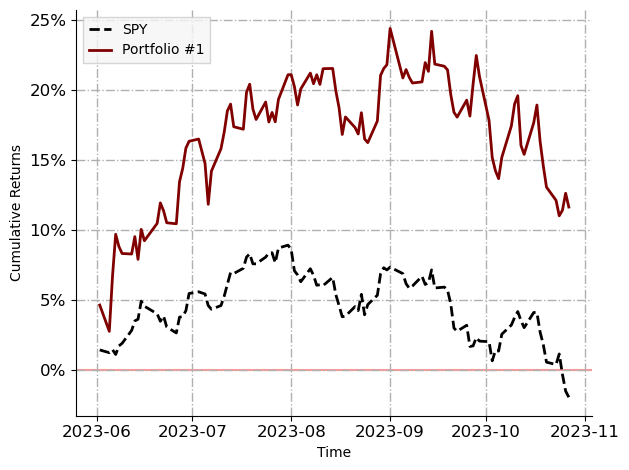

In [135]:
fig, ax=plt.subplots()

ax.plot(tmp.date, tmp.SPY_cum*100, color="black",ls="--", zorder=3,lw=2,label="SPY")
ax.plot(tmp.date, tmp.port_1_cum*100, color="maroon",ls="-", zorder=3,lw=2,label="Portfolio #1")
ax.axhline(0, color="red",zorder=1,alpha=0.4)
ax.grid(lw=1, ls="-.")

# Legend
legend = ax.legend(frameon=True,fancybox=False,loc="upper left",handlelength=1.6,facecolor="whitesmoke")

# Set size of xticks and yticks to 12
ax.tick_params(axis = "both", labelsize = 12)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
# Label x and y axes
ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Returns")
sns.despine()
plt.tight_layout()